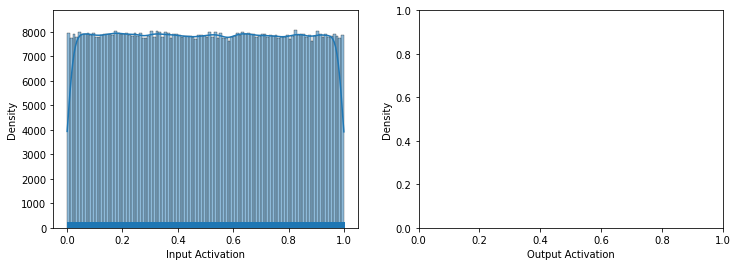

In [195]:
a = torch.rand(16, 64, 768)
b = torch.rand(16, 64, 768)
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(12, 4))            

sns.histplot(data=a.reshape(-1), kde = True, bins=100, ax=ax1)
sns.rugplot(data=a.reshape(-1), ax=ax1)
# sns.histplot(data=b.reshape(-1), kde = True, bins=100, ax=ax2)

            
# sns.distplot(input.reshape(-1).detach().cpu().numpy() , hist = True, rug = True, kde = True, bins=100, norm_hist=False, kde_kws=dict(linewidth=0.5), rug_kws=dict(linewidth=0.5), ax=ax1)
# sns.distplot(output.reshape(-1).detach().cpu().numpy() , hist = True, rug = True, kde = True, bins=100, norm_hist=False, kde_kws=dict(linewidth=0.5), rug_kws=dict(linewidth=0.5), ax=ax2)
# plt.axvline(x=s_init[0].detach().cpu().numpy(), color='r', linestyle='--')
# plt.axvline(x=s_init[1].detach().cpu().numpy(), color='r', linestyle='--')

ax1.set_xlabel("Input Activation")
ax2.set_xlabel("Output Activation")

ax1.set_ylabel("Density")
ax2.set_ylabel("Density")

# ax1.set_title(f"{module.name} Input ACT histogram")
# ax2.set_title(f"{module.name} Output ACT histogram")
# plt.savefig(f"plt_storage/hook_inputs/cola_a2w4_qat/{module.name}.png")

plt.show()

In [255]:
from __future__ import absolute_import, division, print_function

import pprint
import argparse
import logging
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" # Set GPU Index to use
import random
import sys
import pickle
import copy
import collections
import math

import numpy as np
import numpy
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler,TensorDataset
# from torch.utils.tensorboard import SummaryWriter

from torch.nn import CrossEntropyLoss, MSELoss
from tqdm import tqdm
from transformer import BertForSequenceClassification,WEIGHTS_NAME, CONFIG_NAME
from transformer.modeling_quant import BertForSequenceClassification as QuantBertForSequenceClassification
from transformer import BertTokenizer
from transformer import BertAdam
from transformer import BertConfig
from transformer import QuantizeLinear, QuantizeAct, BertSelfAttention, FP_BertSelfAttention
from utils_glue import *
from bertviz import model_view

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn.functional as F

In [256]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0 
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def cv_initialize(model, loader, ratio, device):
    
    def initialize_hook(module, input, output):
        if isinstance(module, (QuantizeLinear, QuantizeAct)):
            """KDLSQ-BERT ACT Quant init Method
            Ref: https://arxiv.org/abs/2101.05938
            """
            if not isinstance(input, torch.Tensor):
                input = input[0]
        
            n = torch.numel(input)
            input_sorted, index = torch.sort(input.reshape(-1), descending=False)
            
            index_min = torch.round(ratio * n / 2)
            index_max = n - index_min
            
            s_init = (input_sorted[int(index_min)].to(device), input_sorted[int(index_max)].to(device))
            
            fig, [ax1, ax2] = plt.subplots(1,2, figsize=(12, 4))            
            
            sns.histplot(data=input.reshape(-1).detach().cpu().numpy(), kde = True, bins=100, ax=ax1)
            sns.rugplot(data=input.reshape(-1).detach().cpu().numpy(), ax=ax1)
            sns.histplot(data=output.reshape(-1).detach().cpu().numpy(), kde = True, bins=100, ax=ax2)
            sns.rugplot(data=output.reshape(-1).detach().cpu().numpy(), ax=ax2)
            # plt.axvline(x=s_init[0].detach().cpu().numpy(), color='r', linestyle='--')
            # plt.axvline(x=s_init[1].detach().cpu().numpy(), color='r', linestyle='--')

            ax1.set_xlabel("Input Activation")
            ax2.set_xlabel("Output Activation")
            
            ax1.set_ylabel("Density")
            ax2.set_ylabel("Density")

            ax1.set_title(f"{module.name} Input ACT histogram")
            ax2.set_title(f"{module.name} Output ACT histogram")
            # plt.savefig(f"plt_storage/hook_inputs/cola_a2w4_qat/{module.name}.png")
            plt.show()
            
            plt.close(fig)
            
            # logger.info(f"{module.name} : min {s_init[0].item()} max {s_init[1].item()}") 
            # module.clip_initialize(s_init)
    
    hooks = []

    for name, module in model.named_modules():
        hook = module.register_forward_hook(initialize_hook)
        hooks.append(hook)
    
    model.train()
    model.to(device)
    
    for step, batch in enumerate(loader):
        batch = tuple(t.to("cuda") for t in batch)
        input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch        
        with torch.no_grad():
            student_logits, student_atts, student_reps, student_probs, student_values = model(input_ids, segment_ids, input_mask, teacher_probs=None)
        break
    
    for hook in hooks:
        hook.remove()

def str2bool(v):
    if isinstance(v, bool):
        return v
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')

def load_vocab(vocab_file):
    """Loads a vocabulary file into a dictionary."""
    vocab = collections.OrderedDict()
    index = 0
    with open(vocab_file, "r", encoding="utf-8") as reader:
        while True:
            token = reader.readline()
            if not token:
                break
            token = token.strip()
            #vocab[token] = index
            vocab[index] = token
            index += 1
    return vocab

def get_tensor_data(output_mode, features):
    if output_mode == "classification":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    elif output_mode == "regression":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.float)


    all_seq_lengths = torch.tensor([f.seq_length for f in features], dtype=torch.long)
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    tensor_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,all_label_ids, all_seq_lengths)
    return tensor_data, all_label_ids

def do_logging(run, student_model, teacher_model, test_dataloader, device, global_step, args, vocab):
    
    nb_steps = 0

    kl_div_sum = [0 for i in range(12)]
    st_sep_avg_sum = [0 for i in range(12)]; st_cls_avg_sum = [0 for i in range(12)]; tc_sep_avg_sum = [0 for i in range(12)]; tc_cls_avg_sum = [0 for i in range(12)]
    cover_sum = [0 for i in range(12)]
    cover_teacher_sum = [0 for i in range(12)]
    
    for batch_num, batch_ in enumerate(test_dataloader):
        batch_ = tuple(t.to(device) for t in batch_)
        
        if batch_num >= 1: # Visualize Attention Map only First Batch 
            args.log_map = False
        
        with torch.no_grad():
            input_ids, input_mask, segment_ids, label_id, seq_length = batch_

            teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_values = teacher_model(input_ids, segment_ids, input_mask)
            student_logits, student_atts, student_reps, student_probs, student_values = student_model(input_ids, segment_ids, input_mask, teacher_probs=teacher_probs)
            
            # Layer
            for i, (student_prob, teacher_prob) in enumerate(zip(student_probs, teacher_probs)): 

                # Head
                for head in range(12):
                    
                    if args.log_map:
                        
                        word_list = []
                        
                        for word in range(seq_length):
                            word_list.append(vocab[input_ids[0][word].item()])
                        
                        student_prob_map = student_prob[0][head][:seq_length,:seq_length].clone().detach().cpu().numpy()
                        teacher_prob_map = teacher_prob[0][head][:seq_length,:seq_length].clone().detach().cpu().numpy()
                        
                        fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16,8))
                        ax1.set_title(f"{i}th Layer {head}th Head Teacher")
                        heatmap = ax1.pcolor(teacher_prob_map, cmap=plt.cm.Blues)
    
                        ax1.set_xticks(numpy.arange(teacher_prob_map.shape[1]) + 0.5, minor=False)
                        ax1.set_yticks(numpy.arange(teacher_prob_map.shape[0]) + 0.5, minor=False)
                        
                        ax1.set_xlim(0, int(teacher_prob_map.shape[1]))
                        ax1.set_ylim(0, int(teacher_prob_map.shape[0]))

                        ax1.invert_yaxis()
                        ax1.xaxis.tick_top()

                        ax1.set_xticklabels(word_list, minor=False)
                        ax1.set_yticklabels(word_list, minor=False)

                        plt.xticks(rotation=45)
                        
                        ax2.set_title(f"{i}th Layer {head}th Head Student")
                        heatmap = ax2.pcolor(student_prob_map, cmap=plt.cm.Blues)

                        ax2.set_xticks(numpy.arange(student_prob_map.shape[1]) + 0.5, minor=False)
                        ax2.set_yticks(numpy.arange(student_prob_map.shape[0]) + 0.5, minor=False)

                        ax2.set_xlim(0, int(student_prob_map.shape[1]))
                        ax2.set_ylim(0, int(student_prob_map.shape[0]))

                        ax2.invert_yaxis()
                        ax2.xaxis.tick_top()

                        ax2.set_xticklabels(word_list, minor=False)
                        ax2.set_yticklabels(word_list, minor=False)

                        plt.xticks(rotation=45)
                        
                        plt_folder_name = os.path.join("plt_storage" + "/" + args.exp_name)
                        if not os.path.exists(plt_folder_name):
                            os.mkdir(plt_folder_name)          
                        plt_folder_name = os.path.join(plt_folder_name, f"step_{global_step}")
                        if not os.path.exists(plt_folder_name):
                            os.mkdir(plt_folder_name)                        
                        plt.savefig(plt_folder_name + "/" + f"L{i}_H{head}.png")
                        plt.close()
                        

                    if args.log_metric:
                        
                        # Attention Map
                        student_attn_map = student_prob[0][head][:seq_length,:seq_length].clone().detach()
                        teacher_attn_map = teacher_prob[0][head][:seq_length,:seq_length].clone().detach()

                        # KL Divergence
                        kl_div = F.kl_div(student_attn_map.log(), teacher_attn_map, reduction='batchmean')
                        kl_div_sum[i] += kl_div

                        # Special Token Prob Mean
                        st_sep_avg = student_attn_map[:,-1].mean()
                        st_cls_avg = student_attn_map[:,0].mean()
                        st_sep_avg_sum[i] += st_sep_avg
                        st_cls_avg_sum[i] += st_cls_avg
                        
                        # Ground Truth
                        tc_sep_avg = teacher_attn_map[:,-1].mean()
                        tc_cls_avg = teacher_attn_map[:,0].mean()
                        tc_sep_avg_sum[i] += tc_sep_avg
                        tc_cls_avg_sum[i] += tc_cls_avg

                        # Coverage Test
                        coverage_head_sum = 0
                        coverage_teacher_head_sum = 0
                        for k in range(student_attn_map.shape[0]):
                            st_argsort = student_attn_map[k].sort(descending=True)[1]
                            tc_argsort = teacher_attn_map[k].sort(descending=True)[1][:args.tc_top_k] # Top-5
                            
                            max_idx = 0
                            for idx in tc_argsort: # Teacher Top-5                             
                                tmp = torch.where(st_argsort == idx)
                                max_idx = max(tmp[0].item(), max_idx)
                            
                            coverage_ratio = max_idx / student_attn_map.shape[0]
                            coverage_teacher_ratio = (args.tc_top_k - 1) / student_attn_map.shape[0]
                            coverage_head_sum += coverage_ratio
                            coverage_teacher_head_sum += coverage_teacher_ratio
                        
                        coverage_head = coverage_head_sum / student_attn_map.shape[0]
                        coverage_teacher_head = coverage_teacher_head_sum / student_attn_map.shape[0]
                        
                        cover_sum[i] += coverage_head
                        cover_teacher_sum[i] += coverage_teacher_head
                        
                        nb_steps += 1
    
    if args.log_metric:
        nb_steps = nb_steps / 12
        
        for l in range(12):
            run[f"attn/L{l}_KLdiv_mean"].log(value=kl_div_sum[l] / nb_steps, step=global_step)
            run[f"attn/L{l}_st_SepProb_mean"].log(value=st_sep_avg_sum[l] / nb_steps, step=global_step)
            run[f"attn/L{l}_st_ClsProb_mean"].log(value=st_cls_avg_sum[l] / nb_steps, step=global_step)
            run[f"attn/L{l}_tc_SepProb_mean"].log(value=tc_sep_avg_sum[l] / nb_steps, step=global_step)
            run[f"attn/L{l}_tc_ClsProb_mean"].log(value=tc_cls_avg_sum[l] / nb_steps, step=global_step)
            run[f"attn/L{l}_st_cover_mean"].log(value=cover_sum[l] / nb_steps, step=global_step)
            run[f"attn/L{l}_tc_cover_mean"].log(value=cover_teacher_sum[l] / nb_steps, step=global_step)

    args.log_map = True
    
                            


def do_eval(model, task_name, eval_dataloader,
            device, output_mode, eval_labels, num_labels, teacher_model=None):
    eval_loss = 0
    nb_eval_steps = 0
    preds = []

    for batch_ in tqdm(eval_dataloader, desc="Inference"):
        batch_ = tuple(t.to(device) for t in batch_)
        
        with torch.no_grad():
            input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch_

            # teacher attnmap test
            if teacher_model is not None:
                logits, teacher_atts, _, teacher_probs, _ = teacher_model(input_ids, segment_ids, input_mask)
                
                logits, _, _, _, _ = model(input_ids, segment_ids, input_mask, teacher_probs=teacher_probs)
            else:
                logits, _, _, _, _ = model(input_ids, segment_ids, input_mask)
        
        # create eval loss and other metric required by the task
        if output_mode == "classification":
            loss_fct = CrossEntropyLoss()
            tmp_eval_loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))
        elif output_mode == "regression":
            loss_fct = MSELoss()
            tmp_eval_loss = loss_fct(logits.view(-1), label_ids.view(-1))

        eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        if len(preds) == 0:
            preds.append(logits.detach().cpu().numpy())
        else:
            preds[0] = np.append(
                preds[0], logits.detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps

    preds = preds[0]
    if output_mode == "classification":
        preds = np.argmax(preds, axis=1)
    elif output_mode == "regression":
        preds = np.squeeze(preds)
    result = compute_metrics(task_name, preds, eval_labels.numpy())
    result['eval_loss'] = eval_loss
    return result

def soft_cross_entropy(predicts, targets):
    student_likelihood = torch.nn.functional.log_softmax(predicts, dim=-1)
    targets_prob = torch.nn.functional.softmax(targets, dim=-1)
    return torch.sum((- targets_prob * student_likelihood), dim=-1).mean()


In [257]:
from bertviz import head_view, model_view
# from bertviz.transformers_neuron_view import BertModel, BertTokenizer
from bertviz.neuron_view import show
import bertviz
bertviz

<module 'bertviz' from '/home/ms/workspace/git/SARQ_BERT/bertviz/__init__.py'>

### Model Dir, Device

In [258]:
task_name = "MNLI"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
################ MODEL DIR ##############
model_dir = os.path.join("output", task_name.lower(), "quant", "SARQ-1step")
# model_dir = os.path.join("output", task_name.lower(), "quant", "ternary_save_A4W2_2")
# model_dir = os.path.join("models",task_name.lower()) 
teacher_model_dir = os.path.join("models",task_name.lower()) 
# student_model_dir = os.path.join("models","cola") 

## Dataset 

In [259]:
num_labels= 3
data_dir = os.path.join("data",task_name)
output_mode = "classification"
processed_data_dir = os.path.join(data_dir,'preprocessed')
dev_file = train_file = os.path.join(processed_data_dir,'dev.pkl') 
eval_features = pickle.load(open(dev_file,'rb'))

eval_data, eval_labels = get_tensor_data("classification", eval_features)
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=1)
eval_data, eval_labels = get_tensor_data(output_mode, eval_features)

In [170]:
tokenizer = BertTokenizer.from_pretrained(model_dir, do_lower_case=True)
processors = ColaProcessor() # Task Name
eval_examples = processors.get_dev_examples(data_dir)
# tokens = tokenizer.convert_ids_to_tokens(test_features[2].input_ids)

FileNotFoundError: [Errno 2] No such file or directory: 'data/MNLI/dev.tsv'

## Teacher Model Build

In [260]:
teacher_model = BertForSequenceClassification.from_pretrained(teacher_model_dir, num_labels=num_labels)
teacher_model.to(device)
teacher_model.eval()
print()

03/10 09:33:24 AM Loading model models/mnli/pytorch_model.bin
03/10 09:33:24 AM loading model...
03/10 09:33:24 AM done!



## Student Model Build

In [261]:
student_config = BertConfig.from_pretrained(model_dir, 
                                                quantize_act=True,
                                                quantize_weight=True,
                                                weight_bits = 2, # Always Ternary when "quantize_weight = True"
                                                input_bits = 4,
                                                clip_val = 2.5,
                                                quantize = True,
                                                ffn_q_1 = True,
                                                ffn_q_2 = True,
                                                qkv_q = True,
                                                emb_q = True,
                                                cls_q = True,
                                                clipping = False,
                                                layer_num = -1,
                                                mean_scale = 0.7,
                                                quantizer = "ternary",
                                                act_quantizer = "lsq",
                                                init_scaling = 1,
                                                clip_ratio = 1,
                                                gradient_scaling = False,
                                                clip_method = "minmax",
                                                teacher_attnmap = False,
                                                parks = False,
                                                stop_grad = False,
                                                qk_FP = False,
                                                map=False
                                                )

03/10 09:33:24 AM loading configuration file output/mnli/quant/SARQ-1step/config.json


In [262]:
student_model = QuantBertForSequenceClassification.from_pretrained(model_dir, config = student_config, num_labels=num_labels)
student_model.to(device)
print()

03/10 09:33:30 AM Loading model output/mnli/quant/SARQ-1step/pytorch_model.bin
03/10 09:33:30 AM loading model...
03/10 09:33:31 AM done!



### ACT, Weight Quant Option 

In [263]:
for name, module in student_model.named_modules():
            if isinstance(module, (QuantizeLinear, QuantizeAct)):    
                module.act_flag = True
                module.weight_flag = True

### ACT Clip Value Initialize

In [91]:
def attention_pattern(model, teacher_model, loader, device):
    
    def initialize_hook(module, input, output):
        if isinstance(module, BertSelfAttention):
            
            attn_mask = input[1]
            attention_output = output[-2]["attn"]
            
            seq_length = (attn_mask == 0).sum()
            
            print(attention_output[0,:,:seq_length,seq_length-1].mean().item())
            

    hooks = []

    for name, module in model.named_modules():
        hook = module.register_forward_hook(initialize_hook)
        hooks.append(hook)
    
    model.eval()
    model.to(device)
    
    for step, batch in enumerate(loader):
        batch = tuple(t.to("cuda") for t in batch)
        input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch        
        with torch.no_grad():
            teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_values = teacher_model(input_ids, segment_ids, input_mask)
            student_logits, student_atts, student_reps, student_probs, student_values = model(input_ids, segment_ids, input_mask, teacher_probs=teacher_probs)
        break
    
    for hook in hooks:
        hook.remove()



In [92]:
#cv_initialize(student_model, eval_dataloader, torch.Tensor([0.005]), device)    
attention_pattern(student_model, teacher_model, eval_dataloader, device)    
print()

0.08793378621339798
0.08709672093391418
0.08762167394161224
0.10184375196695328
0.1046006977558136
0.12444689869880676
0.1124286949634552
0.1064804419875145
0.10368997603654861
0.1322377473115921
0.1139349564909935
0.10247443616390228



## Model Evaluation

In [383]:
task_name = task_name.lower()
print("Student Model Inferece")
student_model.eval()
student_result = do_eval(student_model, task_name, eval_dataloader, device, output_mode, eval_labels, num_labels, teacher_model=teacher_model)
print(f"Student Result : {student_result}")
# print("Teacher Model Inferece")
# teacher_result = do_eval(teacher_model, task_name, eval_dataloader, device, output_mode, eval_labels, num_labels)
# print(f"Teacher Result : {teacher_result}")


Student Model Inferece


Inference: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1043/1043 [00:53<00:00, 19.45it/s]

Student Result : {'mcc': 0.4230837361773732, 'eval_loss': 0.49096661162484984}


### Neuron View

In [264]:
from bertviz.transformers_neuron_view import BertModel, BertTokenizer
from bertviz.neuron_view import show

for name, module in student_model.named_modules():
            if isinstance(module, BertSelfAttention):    
                #print(module.output_bertviz)
                module.output_bertviz = True

for name, module in teacher_model.named_modules():
            if isinstance(module, FP_BertSelfAttention):    
                #print(module.output_bertviz)
                module.output_bertviz = True

model_type = 'bert'
model_version = 'bert-base-uncased'

sentence_a = "the weights made the rope stretch over the pulley."
#sentence_a = "This site includes a list of all award winners and a searchable database of Government Executive articles."
#sentence_b = "The Government Executive articles housed on the website are not able to be searched."
tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=True)
# show(model.to("cpu"), model_type, tokenizer, sentence_a)

03/10 09:33:42 AM loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/ms/.cache/torch/pytorch_transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


In [265]:
show(student_model.cpu(), model_type, tokenizer, sentence_a, display_mode="light")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Model Forward & Get Attention Probs

In [224]:
i = 0
for step, batch in enumerate(eval_dataloader):
    student_model.train()
            
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch
    i = i + 1
    if i == 2:
        break
#     with torch.no_grad():
#         teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_values = teacher_model(input_ids, segment_ids, input_mask)
    
#     student_logits, student_atts, student_reps, student_probs, student_values = student_model(input_ids, segment_ids, input_mask, teacher_probs=None)
input_ids

tensor([[ 101, 2023, 2609, 2950, 1037, 2862, 1997, 2035, 2400, 4791, 1998, 1037,
         3945, 3085, 7809, 1997, 2231, 3237, 4790, 1012,  102, 1996, 2231, 3237,
         4790, 7431, 2006, 1996, 4037, 2024, 2025, 2583, 2000, 2022, 9022, 1012,
          102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]], device='cuda:0')

In [223]:
input_ids_sliced = input_ids[:,:37]
input_ids_sliced
input_id = []
for i in input_ids_sliced[0]:
    input_id.append(i.item())
tokens = tokenizer.convert_ids_to_tokens(input_id)
tokens
# sentence_a = "i'll listen and agree with what i think sounds rignt. i wont's even bother listening."

['[CLS]',
 'this',
 'site',
 'includes',
 'a',
 'list',
 'of',
 'all',
 'award',
 'winners',
 'and',
 'a',
 'search',
 '##able',
 'database',
 'of',
 'government',
 'executive',
 'articles',
 '.',
 '[SEP]',
 'the',
 'government',
 'executive',
 'articles',
 'housed',
 'on',
 'the',
 'website',
 'are',
 'not',
 'able',
 'to',
 'be',
 'searched',
 '.',
 '[SEP]']

In [207]:
student_model = student_model.to(device)
teacher_model = teacher_model.to(device)

In [208]:
for name, module in student_model.named_modules():
            if isinstance(module, BertSelfAttention):    
                print(module.output_bertviz)
                module.output_bertviz = False

for name, module in teacher_model.named_modules():
            if isinstance(module, FP_BertSelfAttention):    
                print(module.output_bertviz)
                module.output_bertviz = False

True
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False


In [252]:
student_logits, student_atts, student_reps, student_probs, student_values = student_model(input_ids_sliced.to(device))
teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_values = teacher_model(input_ids_sliced.to(device))
# model_view(student_probs, tokens, display_mode="light")
student_model.eval()
teacher_model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [253]:
# torch.nn.Softmax(dim=-1)(teacher_atts[0])[0,2,0,:].sum()
for i in range(12):
#     student_atts[i][:,:,:,20] = 0
#     student_atts[i][:,:,:,36] = 0
#     teacher_atts[i][:,:,:,20] = 0
#     teacher_atts[i][:,:,:,36] = 0
    student_atts[i][:,:,:,0] = 0
    teacher_atts[i][:,:,:,0] = 0


In [254]:
seq_length = 13
for i in range(12):
    
    teacher = torch.nn.Softmax(dim=-1)(teacher_atts[i][:,:,:,:])
    student = torch.nn.Softmax(dim=-1)(student_atts[i][:,:,:,:])
    # teacher = teacher_probs[i]
    # student = student_probs[i]
    neg_cross_entropy = teacher * torch.log(student) 
    neg_cross_entropy = torch.sum(neg_cross_entropy, dim=-1)  # (b, h, s, s) -> (b, h, s)
    neg_cross_entropy = torch.sum(neg_cross_entropy, dim=-1) / seq_lengths.view(-1, 1)  # (b, h, s) -> (b, h)

    # p(t) log p(t) = negative entropy
    neg_entropy = teacher * torch.log(teacher) 
    neg_entropy = torch.sum(neg_entropy, dim=-1)  # (b, h, s, s) -> (b, h, s)
    neg_entropy = torch.sum(neg_entropy, dim=-1) / seq_lengths.view(-1, 1)  # (b, h, s) -> (b, h)

    kld_loss = neg_entropy - neg_cross_entropy

    kld_loss_sum = torch.sum(kld_loss)
    print(kld_loss_sum.item())

0.6749075651168823
0.9101618528366089
1.025876760482788
1.0773789882659912
1.0792782306671143
0.9528248310089111
1.235802173614502
1.1162703037261963
1.4301420450210571
1.8933167457580566
1.5252286195755005
0.9004794359207153


## BERT Viz

In [178]:
from transformers import AutoTokenizer, AutoModel, utils
from bertviz import model_view, head_view
# utils.logging.set_verbosity_error()  # Suppress standard warnings

model_name = "microsoft/xtremedistil-l12-h384-uncased"  # Find popular HuggingFace models here: https://huggingface.co/models
input_text = "The cat sat on the mat"  
model = AutoModel.from_pretrained(model_name, output_attentions=True)  # Configure model to return attention values
tokenizer = AutoTokenizer.from_pretrained(model_name)
# inputs = tokenizer.encode(input_text, return_tensors='pt')  # Tokenize input text
# outputs = model(inputs)  # Run model
# attention = outputs[-1]  # Retrieve attention from model outputs
# tokens = tokenizer.convert_ids_to_tokens(inputs[0])  # Convert input ids to token strings
# model_view(attention, tokens)  # Display model view

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [180]:
inputs = tokenizer.encode(input_text, return_tensors='pt')  # Tokenize input text
outputs = model(inputs)  # Run model
attention = outputs[-1]  # Retrieve attention from model outputs
tokens = tokenizer.convert_ids_to_tokens(inputs[0])  # Convert input ids to token strings
head_view(attention, tokens)  # Display model view

<IPython.core.display.Javascript object>